# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add Algorithm folder to current working path in order to access the functions
sys.path.append(parent_directory+"/Src")

CPU times: user 122 µs, sys: 98 µs, total: 220 µs
Wall time: 193 µs


# Import Data

We start by import the AVISO-data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'. We highlight, that the algorithm is general enough to capture also geographic areas close to the coastline or islands. In such regions the velocity field is no longer well defined and the velocity field must be extrapolated to capture coastline effects. We do so by imposing a free-slip boundary.

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u'][:,:,::7]
V = mat_file['v'][:,:,::7]
x = mat_file['x']
y = mat_file['y']
time = mat_file['t'][:,::7]
print(time.shape)

(1, 14)
CPU times: user 134 ms, sys: 32.2 ms, total: 166 ms
Wall time: 166 ms


# Data/Parameters for Dynamical System

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 40

# periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

# list of parameters
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, "Periodic": Periodic}

# Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 30

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define parameters
params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *

DS = Dynamical_System(params_data, params_DS)

CPU times: user 342 ms, sys: 75.8 ms, total: 418 ms
Wall time: 417 ms


## Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 17.8 ms, sys: 3.55 ms, total: 21.3 ms
Wall time: 20.4 ms


## Cauchy Green strain tensor over meshgrid of initial conditions

Next, we compute the Cauchy Green strain tensor for all the initial conditions defined on the meshgrid ('X_domain', 'Y_domain') over the time-interval 'time'. We thereby first calculate the gradient of the flow map using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{20}, \dfrac{1}{100}] $. The computations are parallelized.

In [6]:
%%time
# Import function to calculate Cauchy Green (CG) strain tensor from gradient of Flow map
from ipynb.fs.defs.CauchyGreen import _CauchyGreen
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Define ratio of auxiliary grid vs original meshgrid
aux_grid = 0.1

def parallel(i):
    
    C_ = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(X_domain.shape[1]):
        
        # Point at which to calculate CG tensor
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # Calculate gradient of flow map at 'x' over the time-interval 'time' using an auxiliary grid ratio 'aux_grid'
        grad_Fmap = DS._grad_Fmap(x, time, aux_grid)
        
        C_[j, :, :] = _CauchyGreen(grad_Fmap)
        
    return C_

C = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/802 [00:00<?, ?it/s]

CPU times: user 18.3 s, sys: 3.41 s, total: 21.7 s
Wall time: 23min 5s


## Finite Time Lyapunov Exponent (FTLE)

The FTLE is given by:
\begin{equation}
FTLE_{t_0}^{t_N} = \dfrac{1}{t_N-t_0}\log(\sqrt{\lambda_{2}(C_{t_0}^{t_N}(\mathbf{x})}), 
\end{equation} with $ \lambda_{2}(C_{t_0}^{t_N}(\mathbf{x}) $ denoting the maximum eigenvalue associated to the Cauchy Green strain tensor over the time-interval $ [t_0, t_N] $

In [7]:
# Function which computes FTLE from CG tensor
from ipynb.fs.defs.FTLE import _FTLE

# Compute FTLE from CG tensor
FTLE = _FTLE(C, tN-t0)

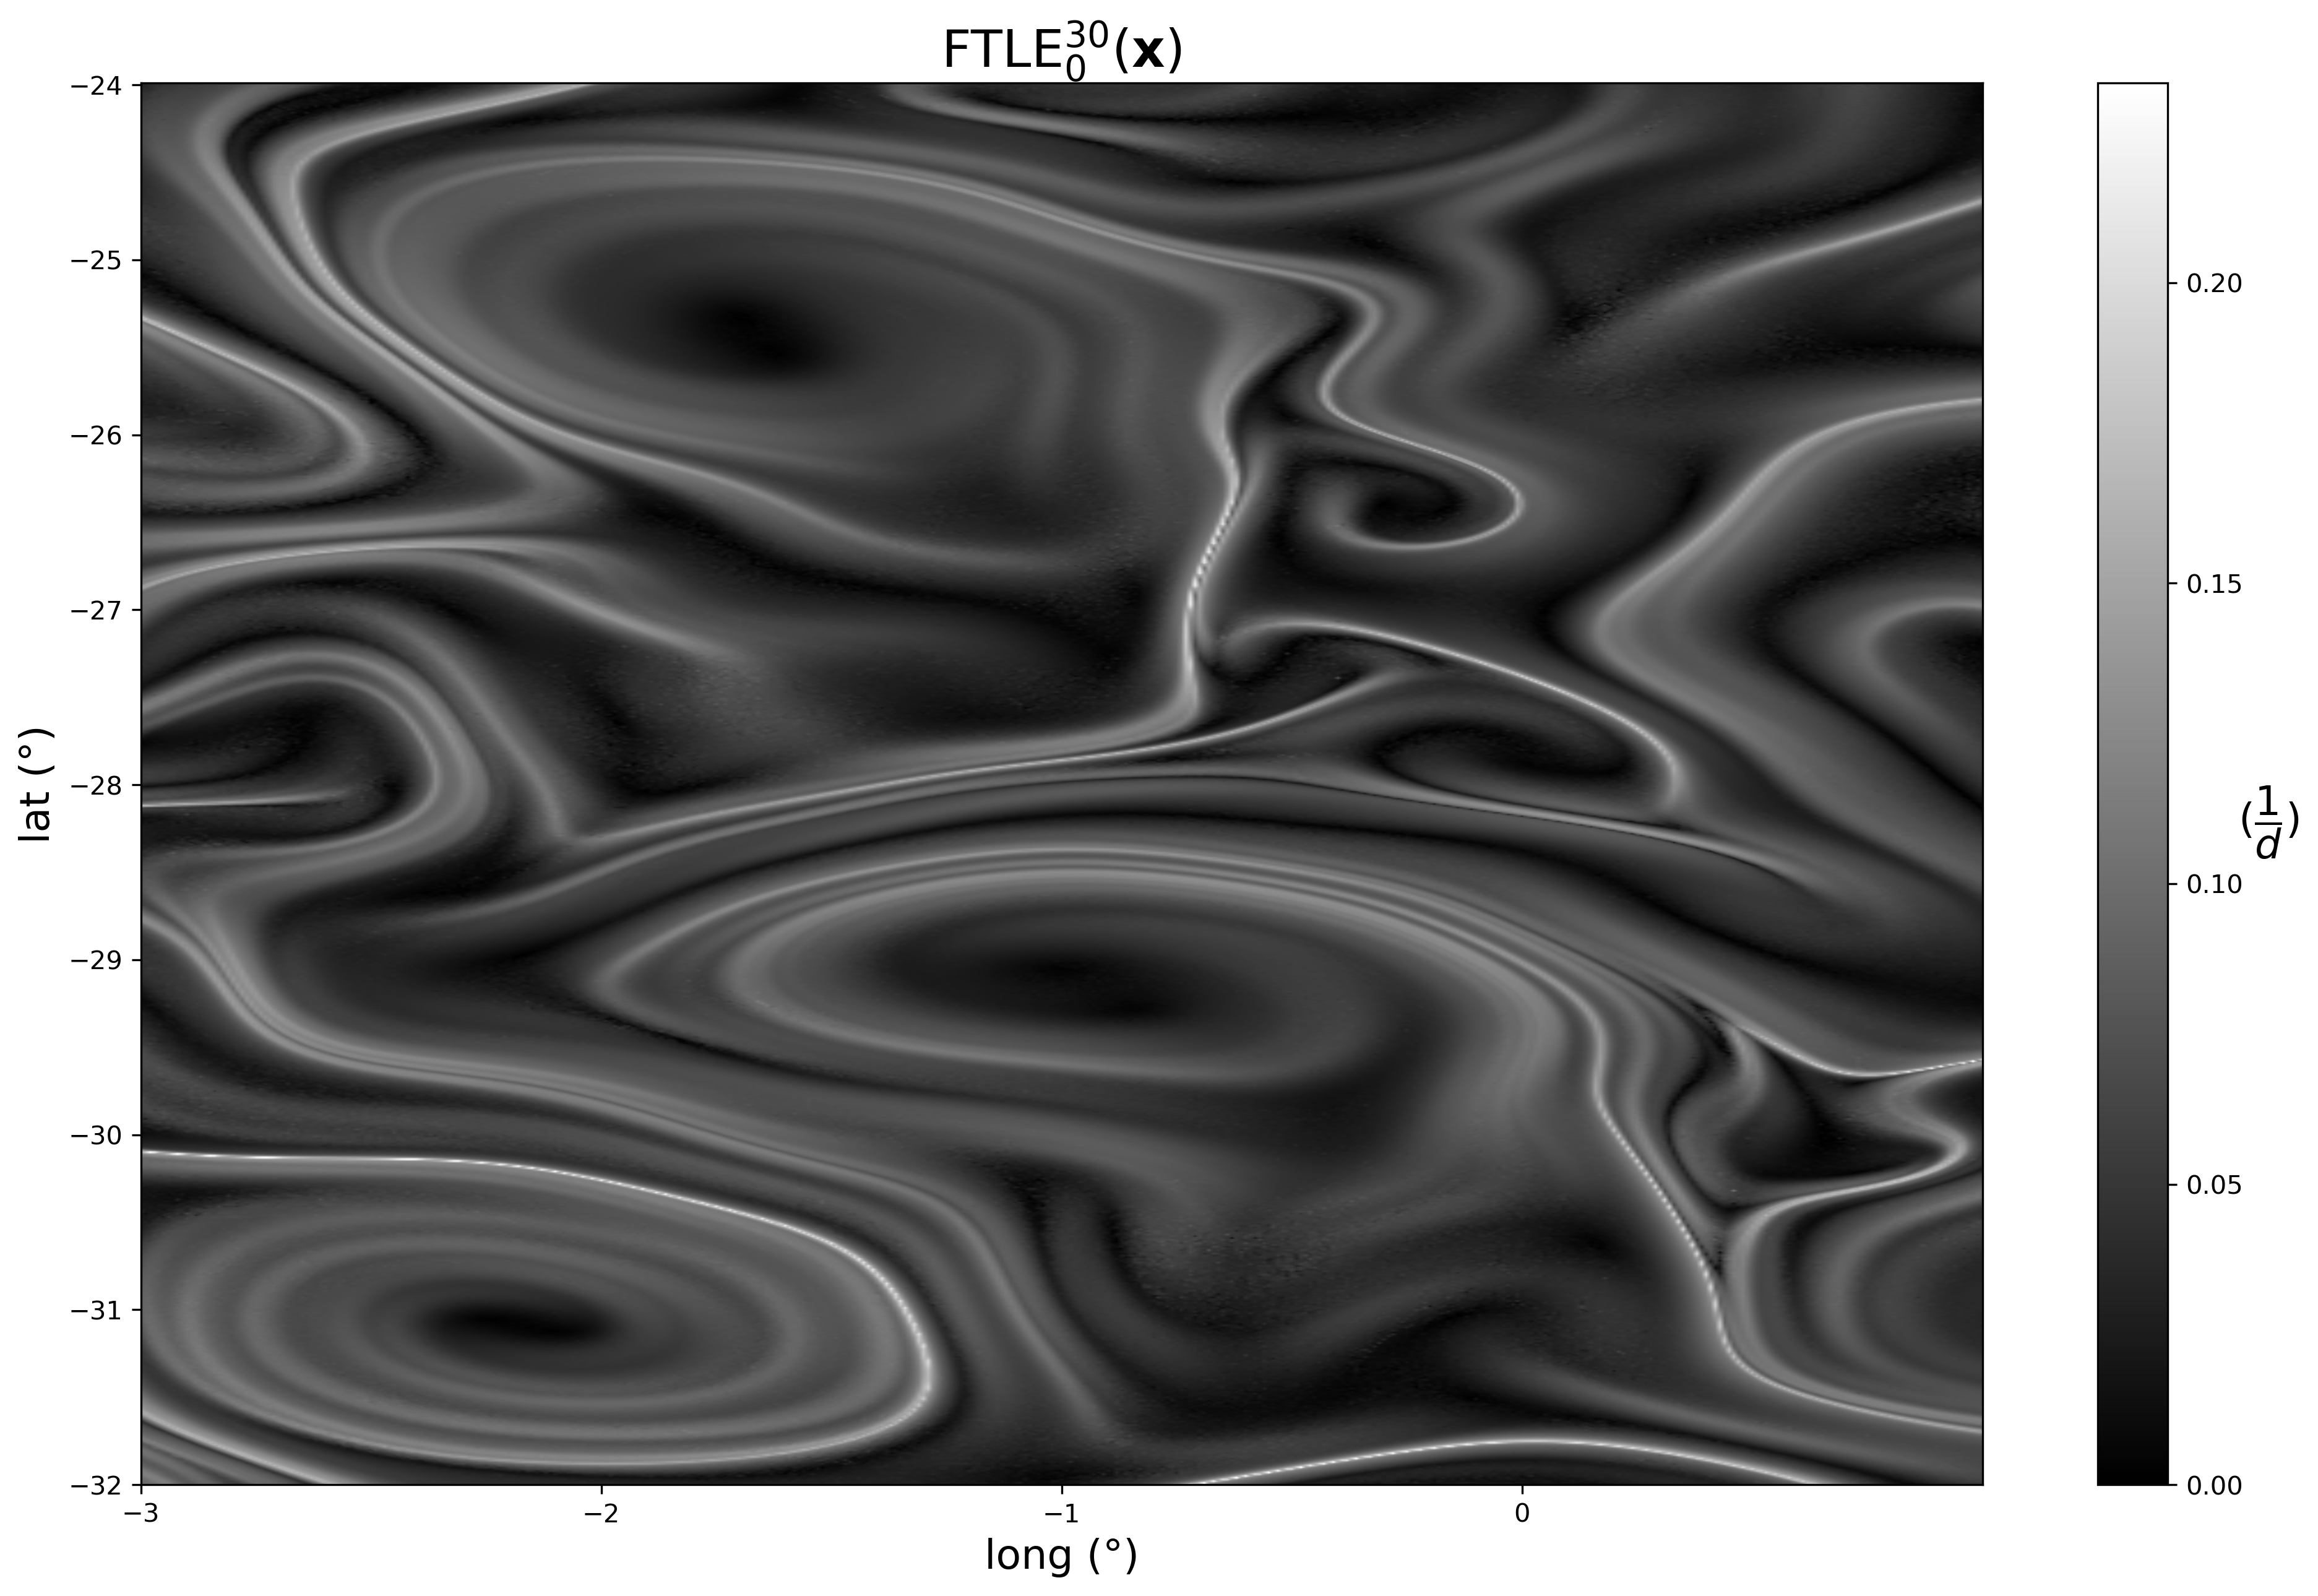

In [8]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(16, 10), dpi = 300)
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, FTLE, cmap = "gist_gray", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 16)

# Title
ax.set_title(r'$ \mathrm{FTLE}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 20)

plt.show()